In [1]:
import warnings;warnings.filterwarnings('ignore')

import re
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.spatial import cKDTree


# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver5.csv'
test_path  = f'{data_path}/new/new_test_ver5.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
df = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

Train data shape :  (1118822, 186) Test data shape :  (9272, 185)


In [3]:
list(df.columns)

['본번',
 '부번',
 '아파트명',
 '전용면적',
 '층',
 '건축년도',
 '도로명',
 '해제사유발생일',
 '등기신청일자',
 '거래유형',
 '부동산유형',
 '분양형태',
 'k-관리방식',
 'k-복도유형',
 'k-난방방식',
 'k-전체동수',
 'k-전체세대수',
 'k-건설사',
 'k-사용검사일-사용승인일',
 'k-연면적',
 'k-주거전용면적',
 'k-관리비부과면적',
 'k-등록일자',
 'k-수정일자',
 '건축면적',
 '주차대수',
 '단지승인일',
 '좌표X',
 '좌표Y',
 '단지신청일',
 'target',
 '구',
 '동',
 '계약날짜',
 '계약날짜_경과일',
 'BYC',
 'GS건설',
 'JR건설',
 'KCC건설',
 'KR산업',
 'LG건설',
 'LIG건설',
 'SH공사',
 'SK건설',
 'TEC건설',
 'unknown',
 '갑을건설',
 '건설알포메',
 '건영',
 '경남기업',
 '경동건설',
 '경향건설',
 '계룡건설',
 '고려개발',
 '고려산업개발',
 '고속도로관리공단',
 '공영토건',
 '극동건설',
 '금하건설',
 '금호건설',
 '나산건설',
 '남광건설',
 '남해건설',
 '대동건설',
 '대림산업',
 '대명종합건설',
 '대백건설',
 '대보건설',
 '대성산업',
 '대우건설',
 '대주건설',
 '대창건설',
 '대한전척',
 '대한주택공사',
 '대호아이피종합건설',
 '도시공감',
 '돈암정릉구역주택재개발정비사업조합',
 '동방티앤씨',
 '동부건설',
 '동선구역주택재개발조합',
 '동성개발',
 '동아건설',
 '동양메이저건설',
 '동원산업건설',
 '동일건설',
 '동일토건',
 '동일하이빌',
 '두산건설',
 '두산건설주식회사',
 '두진',
 '라성건설',
 '라이프건설',
 '라인건설',
 '럭키개발',
 '롯데건설',
 '문영건설',
 '미원건설',
 '미주건설',
 '박연정',
 '벽산건설',
 '보람건설',
 '삼부토건',
 

# 2.GDP 추가

In [4]:
kor_gdp = pd.read_csv(f"{data_path}/new/kor-gdp.csv")
kor_gdp.head()

,통계표,계정항목,단위,변환,2001,2002,2003,2004,2005,2006,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,9.1.4.2. 국제 주요국 국내총생산(GDP),한국,백만달러,원자료,"547,743.1","626,989.2","702,696.2","792,532.0","934,707.9","1,052,610.2",...,"1,484,488.5","1,466,038.9","1,499,679.8","1,623,074.1","1,725,373.4","1,651,422.9","1,644,312.8","1,818,432.2","1,673,916.5","1,712,792.9"


In [5]:
gdp_data_cleaned = kor_gdp.melt(id_vars=["통계표", "계정항목", "단위", "변환"], 
                                 var_name="Year", 
                                 value_name="GDP")
gdp_data_cleaned = gdp_data_cleaned[gdp_data_cleaned["계정항목"] == "한국"]
gdp_data_cleaned = gdp_data_cleaned[["Year", "GDP"]]
gdp_data_cleaned["Year"] = gdp_data_cleaned["Year"].astype(int)
gdp_data_cleaned["GDP"] = gdp_data_cleaned["GDP"].str.replace(',', '').astype(float)

df['계약날짜'] = pd.to_datetime(df['계약날짜'])
df['Year'] = df['계약날짜'].dt.year

df = pd.merge(df, gdp_data_cleaned, on='Year', how='left')
df = df.drop(columns=['Year'])

In [6]:
df.head()

,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,...,현산,현진종합건설,혜림건설,호반건설,홍익종합건업,효성건설,흑석5구역재개발조합,흥화건설,is_test,GDP
0,0.354562,0.000352,개포6차우성,0.554490,0.095890,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0,1623074.1
1,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0,1623074.1
2,0.354562,0.000352,개포6차우성,0.454466,0.123288,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0,1623074.1
3,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0,1725373.4
4,0.354562,0.000352,개포6차우성,0.554490,0.082192,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0,1725373.4


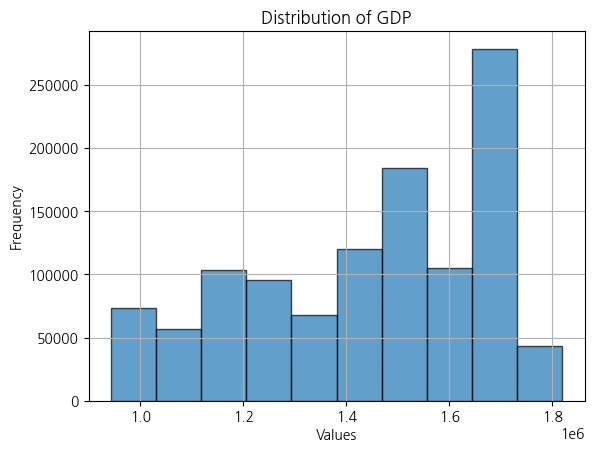

In [7]:
plt.hist(df['GDP'], edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

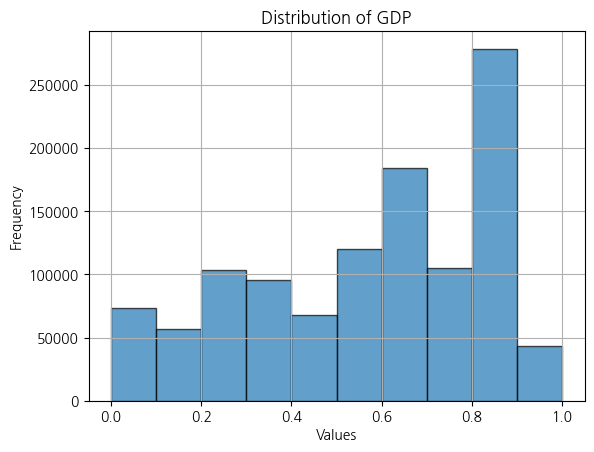

In [8]:
scaler = MinMaxScaler()
df['GDP'] = scaler.fit_transform(df[['GDP']])

plt.hist(df['GDP'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 기준금리 추가

In [9]:
kor_ir = pd.read_csv(f"{data_path}/new/kor-ir.csv")
kor_ir.head()

,Interest Rate Type,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,기준금리,5.0,3.0,2.0,2.5,3.25,2.75,2.5,2.0,1.5,1.25,1.5,1.75,1.25,0.5,1.0,3.25,3.5


In [10]:
df['계약연도'] = pd.to_datetime(df['계약날짜']).dt.year
df['계약연도'] = df['계약연도'].astype(int)

interest_rate_data_transposed = kor_ir.set_index('Interest Rate Type').T
interest_rate_data_transposed.index = interest_rate_data_transposed.index.astype(int)

df['IR'] = df['계약연도'].map(interest_rate_data_transposed['기준금리'])
df = df.drop(columns=['계약연도'])

In [11]:
df.head()

,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,...,현진종합건설,혜림건설,호반건설,홍익종합건업,효성건설,흑석5구역재개발조합,흥화건설,is_test,GDP,IR
0,0.354562,0.000352,개포6차우성,0.554490,0.095890,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0.776663,1.50
1,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0.776663,1.50
2,0.354562,0.000352,개포6차우성,0.454466,0.123288,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0.776663,1.50
3,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0.893613,1.75
4,0.354562,0.000352,개포6차우성,0.554490,0.082192,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0,0,0,0,0.893613,1.75


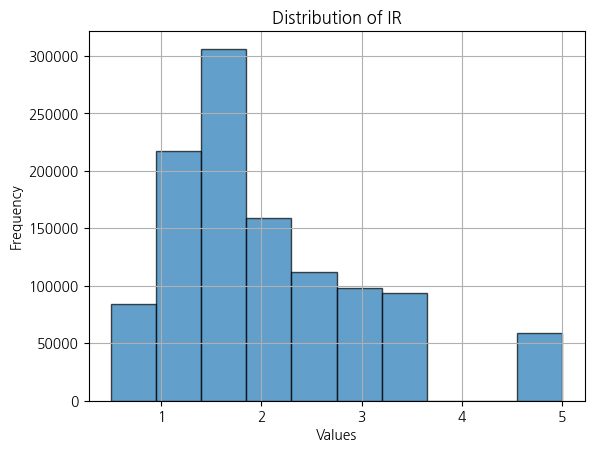

In [12]:
plt.hist(df['IR'], edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

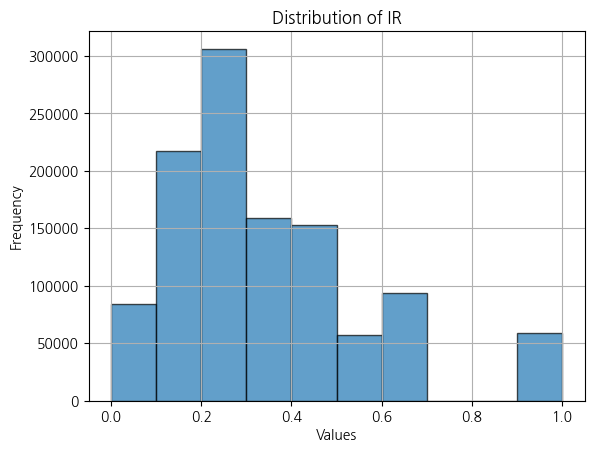

In [13]:
scaler = MinMaxScaler()
df['IR'] = scaler.fit_transform(df[['IR']])

plt.hist(df['IR'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of IR')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4.지하철, 버스 추가

In [14]:
subway_df = pd.read_csv(f"{data_path}/subway_feature.csv")
print(subway_df.shape)
subway_df.head()

(768, 5)


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


In [15]:
bus_df = pd.read_csv(f"{data_path}/bus_feature.csv")
print(bus_df.shape)
bus_df.head()

(12584, 6)


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [16]:
print(df['좌표X'].min(), df['좌표X'].max())
print(df['좌표Y'].min(), df['좌표Y'].max())

126.7983185 127.1799976
37.4344200706203 37.6877248


In [17]:
# 고유한 X, Y 좌표 쌍 추출
unique_coordinates = df[['좌표X', '좌표Y']].drop_duplicates()

# KD-트리 생성
bus_tree = cKDTree(bus_df[['X좌표', 'Y좌표']].values)
subway_tree = cKDTree(subway_df[['경도', '위도']].values)

def count_nearby_stations_kdtree(row, bus_tree, subway_tree, bus_stops, subway_stations, threshold=0.5):
    # threshold는 km 단위로 그대로 사용
    threshold_in_km = threshold  # 0.5 km = 500 meters

    # 버스 정류장 근처 개수
    bus_indices = bus_tree.query_ball_point([row['좌표X'], row['좌표Y']], r=threshold_in_km)
    bus_count = sum(great_circle((row['좌표Y'], row['좌표X']), (bus_stops.iloc[i]['Y좌표'], bus_stops.iloc[i]['X좌표'])).km <= threshold for i in bus_indices)

    # 지하철역 근처 개수
    subway_indices = subway_tree.query_ball_point([row['좌표X'], row['좌표Y']], r=threshold_in_km)
    subway_count = sum(great_circle((row['좌표Y'], row['좌표X']), (subway_stations.iloc[i]['위도'], subway_stations.iloc[i]['경도'])).km <= threshold for i in subway_indices)

    return bus_count, subway_count

# 고유한 좌표 쌍에 대해 계산
unique_coordinates[['인근_버스정류장수', '인근_지하철역수']] = unique_coordinates.apply(
    count_nearby_stations_kdtree, axis=1, bus_tree=bus_tree, subway_tree=subway_tree, bus_stops=bus_df, subway_stations=subway_df, threshold=0.5, result_type="expand")

# 원래 데이터프레임에 결과를 반영
df = df.merge(unique_coordinates, on=['좌표X', '좌표Y'], how='left')

In [28]:
list(df.columns)

['본번',
 '부번',
 '아파트명',
 '전용면적',
 '층',
 '건축년도',
 '도로명',
 '해제사유발생일',
 '등기신청일자',
 '거래유형',
 '부동산유형',
 '분양형태',
 'k-관리방식',
 'k-복도유형',
 'k-난방방식',
 'k-전체동수',
 'k-전체세대수',
 'k-건설사',
 'k-사용검사일-사용승인일',
 'k-연면적',
 'k-주거전용면적',
 'k-관리비부과면적',
 'k-등록일자',
 'k-수정일자',
 '건축면적',
 '주차대수',
 '단지승인일',
 '좌표X',
 '좌표Y',
 '단지신청일',
 'target',
 '구',
 '동',
 '계약날짜',
 '계약날짜_경과일',
 'BYC',
 'GS건설',
 'JR건설',
 'KCC건설',
 'KR산업',
 'LG건설',
 'LIG건설',
 'SH공사',
 'SK건설',
 'TEC건설',
 'unknown',
 '갑을건설',
 '건설알포메',
 '건영',
 '경남기업',
 '경동건설',
 '경향건설',
 '계룡건설',
 '고려개발',
 '고려산업개발',
 '고속도로관리공단',
 '공영토건',
 '극동건설',
 '금하건설',
 '금호건설',
 '나산건설',
 '남광건설',
 '남해건설',
 '대동건설',
 '대림산업',
 '대명종합건설',
 '대백건설',
 '대보건설',
 '대성산업',
 '대우건설',
 '대주건설',
 '대창건설',
 '대한전척',
 '대한주택공사',
 '대호아이피종합건설',
 '도시공감',
 '돈암정릉구역주택재개발정비사업조합',
 '동방티앤씨',
 '동부건설',
 '동선구역주택재개발조합',
 '동성개발',
 '동아건설',
 '동양메이저건설',
 '동원산업건설',
 '동일건설',
 '동일토건',
 '동일하이빌',
 '두산건설',
 '두산건설주식회사',
 '두진',
 '라성건설',
 '라이프건설',
 '라인건설',
 '럭키개발',
 '롯데건설',
 '문영건설',
 '미원건설',
 '미주건설',
 '박연정',
 '벽산건설',
 '보람건설',
 '삼부토건',
 

In [23]:
df['인근_버스정류장수'].value_counts()

인근_버스정류장수
23    56608
19    51366
22    48593
25    48022
21    46135
      ...  
57      285
68      241
61      177
59      105
65       22
Name: count, Length: 68, dtype: int64

In [24]:
df['인근_지하철역수'].value_counts()

인근_지하철역수
0    530072
1    455191
2    117236
3     16045
4      5376
5      3700
6       474
Name: count, dtype: int64

In [30]:
# 고유한 X, Y 좌표 쌍 추출
unique_coordinates = df[['좌표X', '좌표Y']].drop_duplicates()

# KD-트리 생성
bus_tree = cKDTree(bus_df[['X좌표', 'Y좌표']].values)
subway_tree = cKDTree(subway_df[['경도', '위도']].values)

def find_nearest_kdtree(point, tree, locations, lat_col, lon_col):
    distance, idx = tree.query(point, k=1)
    nearest_point = locations.iloc[idx]
    nearest_distance = geodesic((point[1], point[0]), (nearest_point[lat_col], nearest_point[lon_col])).meters
    return nearest_distance

# 고유한 좌표 쌍에 대해 최근접 버스정류장과 지하철역 거리 계산
unique_coordinates['최근접_버스정류장'] = unique_coordinates.apply(
    lambda row: find_nearest_kdtree([row['좌표X'], row['좌표Y']], bus_tree, bus_df, 'Y좌표', 'X좌표'), axis=1)

unique_coordinates['최근접_지하철역'] = unique_coordinates.apply(
    lambda row: find_nearest_kdtree([row['좌표X'], row['좌표Y']], subway_tree, subway_df, '위도', '경도'), axis=1)

# 원래 데이터프레임에 결과를 반영
df = df.merge(unique_coordinates, on=['좌표X', '좌표Y'], how='left')

In [31]:
df['최근접_버스정류장'].value_counts()

최근접_버스정류장
286.310718    4422
55.419371     4263
184.258241    4101
197.034646    3551
33.820410     3237
              ... 
69.337662        1
355.237385       1
19.416722        1
247.974592       1
158.751871       1
Name: count, Length: 9164, dtype: int64

In [32]:
df['최근접_지하철역'].value_counts()

최근접_지하철역
125.479635    4422
340.842504    4263
393.235987    4101
389.159020    3551
690.048834    3237
              ... 
529.554086       1
692.843336       1
515.789793       1
364.527006       1
328.318921       1
Name: count, Length: 9164, dtype: int64

In [33]:
list(df.columns)

['본번',
 '부번',
 '아파트명',
 '전용면적',
 '층',
 '건축년도',
 '도로명',
 '해제사유발생일',
 '등기신청일자',
 '거래유형',
 '부동산유형',
 '분양형태',
 'k-관리방식',
 'k-복도유형',
 'k-난방방식',
 'k-전체동수',
 'k-전체세대수',
 'k-건설사',
 'k-사용검사일-사용승인일',
 'k-연면적',
 'k-주거전용면적',
 'k-관리비부과면적',
 'k-등록일자',
 'k-수정일자',
 '건축면적',
 '주차대수',
 '단지승인일',
 '좌표X',
 '좌표Y',
 '단지신청일',
 'target',
 '구',
 '동',
 '계약날짜',
 '계약날짜_경과일',
 'BYC',
 'GS건설',
 'JR건설',
 'KCC건설',
 'KR산업',
 'LG건설',
 'LIG건설',
 'SH공사',
 'SK건설',
 'TEC건설',
 'unknown',
 '갑을건설',
 '건설알포메',
 '건영',
 '경남기업',
 '경동건설',
 '경향건설',
 '계룡건설',
 '고려개발',
 '고려산업개발',
 '고속도로관리공단',
 '공영토건',
 '극동건설',
 '금하건설',
 '금호건설',
 '나산건설',
 '남광건설',
 '남해건설',
 '대동건설',
 '대림산업',
 '대명종합건설',
 '대백건설',
 '대보건설',
 '대성산업',
 '대우건설',
 '대주건설',
 '대창건설',
 '대한전척',
 '대한주택공사',
 '대호아이피종합건설',
 '도시공감',
 '돈암정릉구역주택재개발정비사업조합',
 '동방티앤씨',
 '동부건설',
 '동선구역주택재개발조합',
 '동성개발',
 '동아건설',
 '동양메이저건설',
 '동원산업건설',
 '동일건설',
 '동일토건',
 '동일하이빌',
 '두산건설',
 '두산건설주식회사',
 '두진',
 '라성건설',
 '라이프건설',
 '라인건설',
 '럭키개발',
 '롯데건설',
 '문영건설',
 '미원건설',
 '미주건설',
 '박연정',
 '벽산건설',
 '보람건설',
 '삼부토건',
 

In [34]:
df.head(20)

,본번,부번,아파트명,전용면적,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,...,효성건설,흑석5구역재개발조합,흥화건설,is_test,GDP,IR,인근_버스정류장수,인근_지하철역수,최근접_버스정류장,최근접_지하철역
0,0.354562,0.000352,개포6차우성,0.554490,0.095890,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.776663,0.222222,13,0,61.895840,1127.738351
1,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.776663,0.222222,13,0,61.895840,1127.738351
2,0.354562,0.000352,개포6차우성,0.454466,0.123288,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.776663,0.222222,13,0,61.895840,1127.738351
3,0.354562,0.000352,개포6차우성,0.554490,0.109589,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
4,0.354562,0.000352,개포6차우성,0.554490,0.082192,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
5,0.354562,0.000352,개포6차우성,0.554490,0.068493,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
6,0.354562,0.000352,개포6차우성,0.554490,0.082192,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
7,0.354562,0.000352,개포6차우성,0.454466,0.123288,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
8,0.354562,0.000352,개포6차우성,0.554490,0.095890,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351
9,0.354562,0.000352,개포6차우성,0.454466,0.095890,0.419355,언주로 3,NaN,,0,...,0,0,0,0,0.893613,0.277778,13,0,61.895840,1127.738351


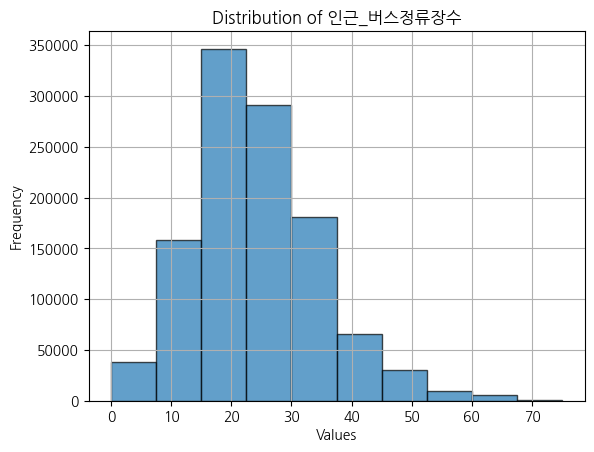

In [35]:
plt.hist(df['인근_버스정류장수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

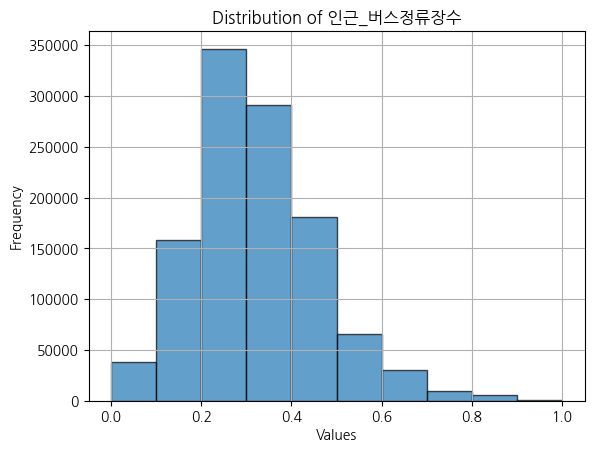

In [36]:
scaler = MinMaxScaler()
df['인근_버스정류장수'] = scaler.fit_transform(df[['인근_버스정류장수']])

plt.hist(df['인근_버스정류장수'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

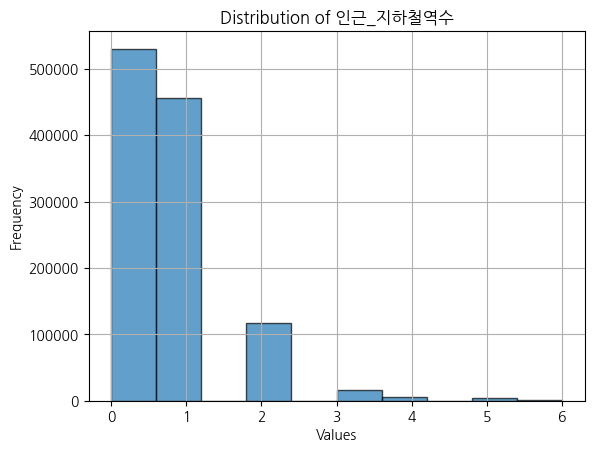

In [37]:
plt.hist(df['인근_지하철역수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

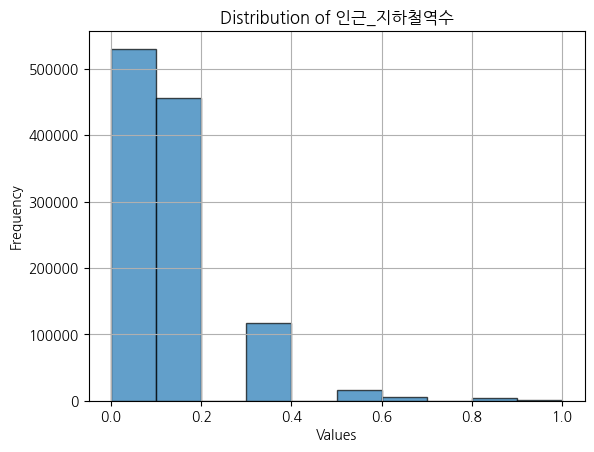

In [38]:
scaler = MinMaxScaler()
df['인근_지하철역수'] = scaler.fit_transform(df[['인근_지하철역수']])

plt.hist(df['인근_지하철역수'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

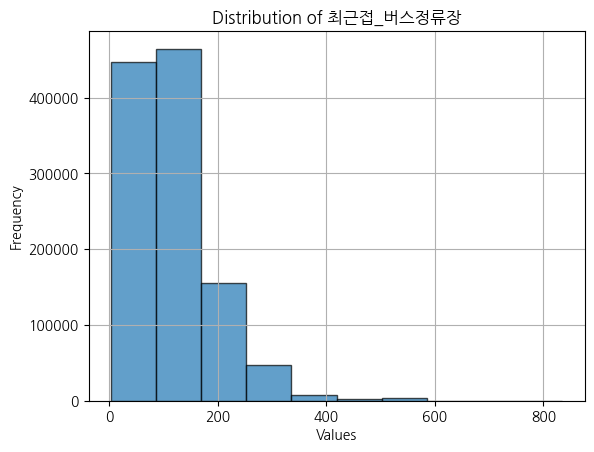

In [39]:
plt.hist(df['최근접_버스정류장'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

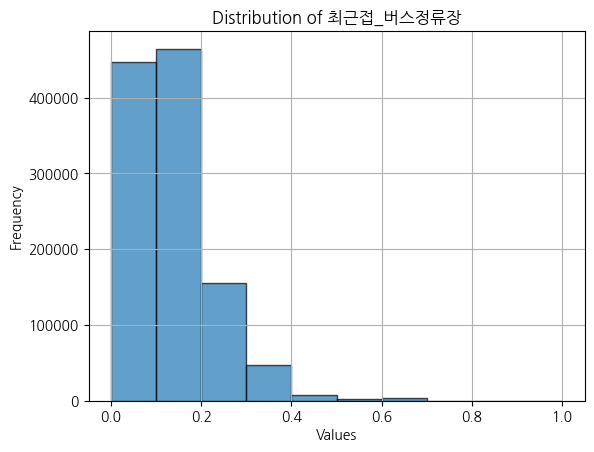

In [40]:
scaler = MinMaxScaler()
df['최근접_버스정류장'] = scaler.fit_transform(df[['최근접_버스정류장']])

plt.hist(df['최근접_버스정류장'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

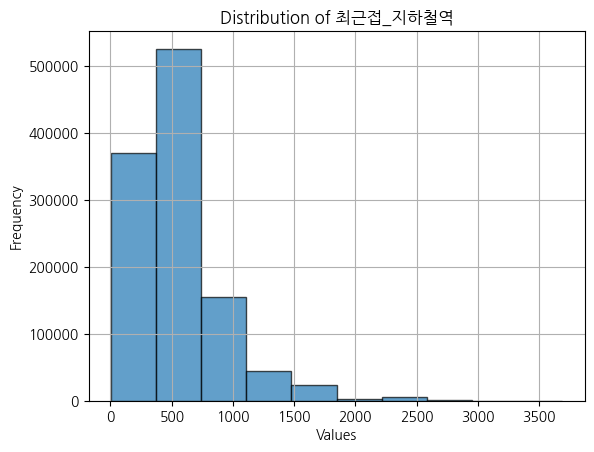

In [41]:
plt.hist(df['최근접_지하철역'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

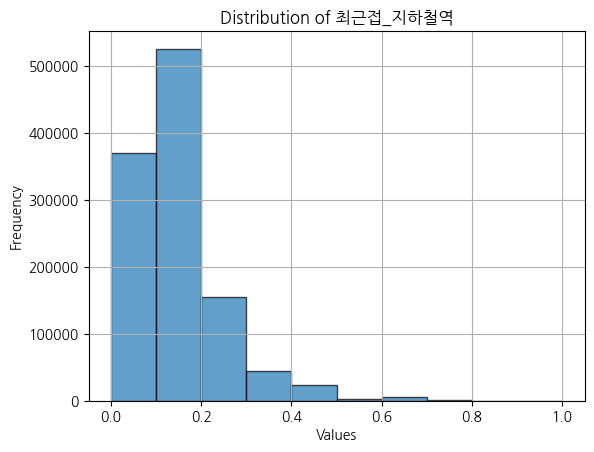

In [42]:
scaler = MinMaxScaler()
df['최근접_지하철역'] = scaler.fit_transform(df[['최근접_지하철역']])

plt.hist(df['최근접_지하철역'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [44]:
train_df = df[df['is_test'] == 0]
test_df = df[df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

train_df.to_csv(f'{data_path}/new/new_train_ver6.csv', index=False)
test_df.to_csv(f'{data_path}/new/new_test_ver6.csv', index=False)

(1118822, 192) (9272, 191)
